In [1]:
# Fit Forward, 9 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 9

In [8]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, nobad, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    
    if len(primary_river.iloc[spoint-8:spoint]) != 8:
        print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        nobad = nobad + 1
        allbad = True
    else:
        allbad = False
        for ii in range(1, 8):
            jj = ii + gap_length - 1        
            persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
            if ii > 1:
                b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
                linear[ii-2] = b + m * jj
            if ii > 2:
                b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
                cubic[ii-3] = b + m * jj + c * jj**2

        if fittype == 'fit':
            useriver = matching_dictionary[river]
        elif fittype == 'backup':
            useriver = backup_dictionary[river]
        firstchoice = read_river(useriver, 'primary')
        for jj, length in enumerate(fitlength):
            for ii in range(length):
                denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
                if len(denom) == 1:
                    ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                                firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
                else:
                    bad = True
            if not bad:
                numer = firstchoice[firstchoice.index == primary_river.index[point]].values
                if len(numer) != 1:
                    print ('Numer catch')
                    bad = True
                else:
                    fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
        if bad:
            fittedbad = fittedbad + 1
        if doplots:
            ax.plot(persist)
            ax.plot(range(1, 7), linear)
            ax.plot(range(2, 7), cubic)
            if not bad:
                ax.plot(fitted)
            ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
            ax.plot(7, primary_river.iloc[spoint].values, 'x')
            ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
            ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad, allbad, nobad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [12]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, nobad, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad, allbad, nobad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, nobad, doplots)

    if not allbad:
        GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
        accumulateG += GG
        accumulateC += CC
        accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad, nobad

In [13]:
print (gap_length)

9


In [14]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
Numer catch
Numer catch
Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  956.  956.  956.  956.] [ 104.61314063  104.07358258  104.57545462  105.43462094  105.92300769
  105.90790958  106.12035358  300.38420059  273.34043061  253.84036435
  238.25460628  219.08329801  205.13351643 1601.83139339 1274.27456057
 1030.81272197  869.03558726  753.29088774   58.86881036   59.67878678
   61.28672214   65.00540638] [0.149      0.142      0.144      0.147      0.151      0.144
 0.142      0.481      0.47       0.478      0.464      0.45
 0.412      0.76       0.733      0.7        0.709      0.702
 0.04811715 0.0460251  0.0460251  0.04707113] [0.         0.         0.         0.         0.         0.
 0.         0.186      0.17       0.162      0.164      0.151
 0.147      0.425      0.4        0.359      0.36       0.347
 0.00523013 0.00313808 0.00209205 0.00313808]


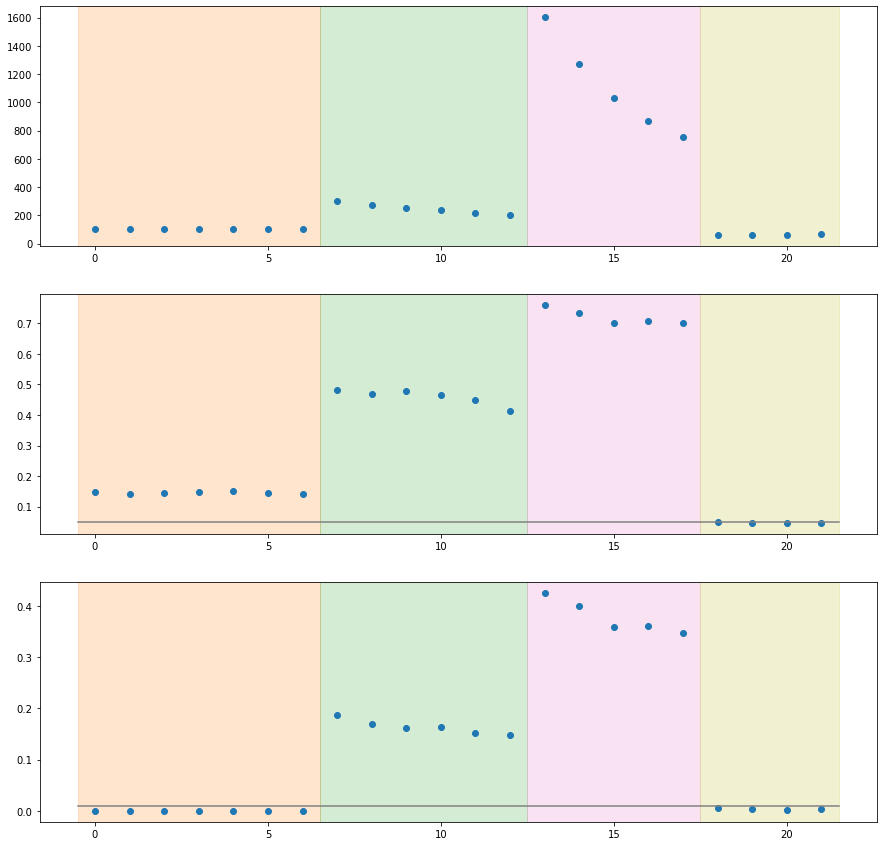

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [16]:
print (gap_length)

9


In [17]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


0 Primary River Flow    100.5246
Name: 1970-01-07 00:00:00, dtype: float64
realized 999
[999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.
 999. 999. 999. 999. 998. 998. 998. 998.] [ 145.22380112  145.351878    144.60901349  144.40806352  144.83302315
  144.70156875  144.47733056  461.61637947  401.45786158  377.81208427
  360.7707805   337.19188759  317.62011597 2831.77575799 1959.25421934
 1535.62442855 1260.0233089  1099.55331235   77.51998245   75.90337462
   77.23022262   79.7562165 ] [0.21221221 0.21421421 0.20920921 0.21221221 0.21621622 0.21421421
 0.21421421 0.63663664 0.58758759 0.57157157 0.57057057 0.54954955
 0.54554555 0.78478478 0.77677678 0.76376376 0.72672673 0.71971972
 0.05511022 0.05210421 0.04809619 0.04709419] [0.         0.         0.         0.         0.         0.
 0.         0.27827828 0.23623624 0.21121121 0.21521522 0.1961962
 0.18718719 0.42442442 0.40840841 0.37237237 0.36736737 0.34734735
 0.00300601 0.00300601 0.00200401 0.        ]


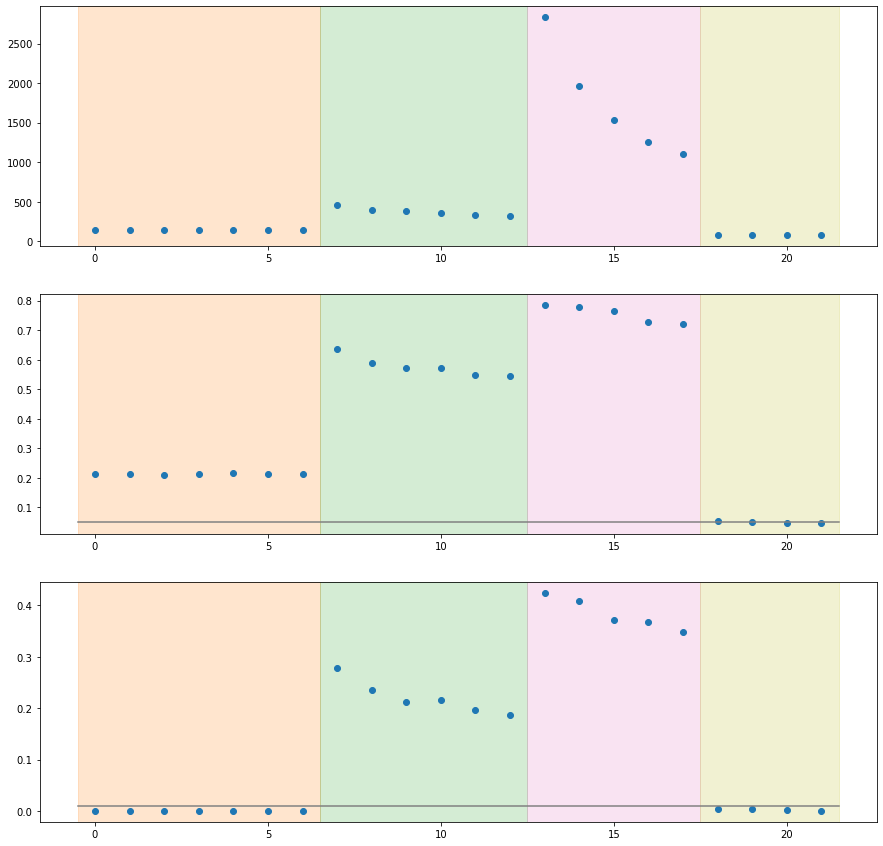

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [19]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [ 161.7149748   158.17212015  158.3300803   157.34434893  157.06666072
  157.51719993  157.56393539  616.9972657   529.22427763  451.93724631
  408.27958081  378.83346737  351.55460619 3451.9465621  2645.76317593
 2162.1326877  1706.80205407 1379.607495    147.14014085  151.474866
  157.14653262  166.49110628] [0.095      0.091      0.099      0.101      0.091      0.09
 0.085      0.525      0.454      0.446      0.412      0.381
 0.363      0.891      0.818      0.794      0.76       0.723
 0.04408818 0.04809619 0.04709419 0.05511022] [0.         0.         0.         0.         0.         0.
 0.         0.276      0.23       0.2        0.167      0.141
 0.129      0.534      0.468      0.463      0.413      0.391
 0.00300601 0.001002   0.001002   0.00200401]


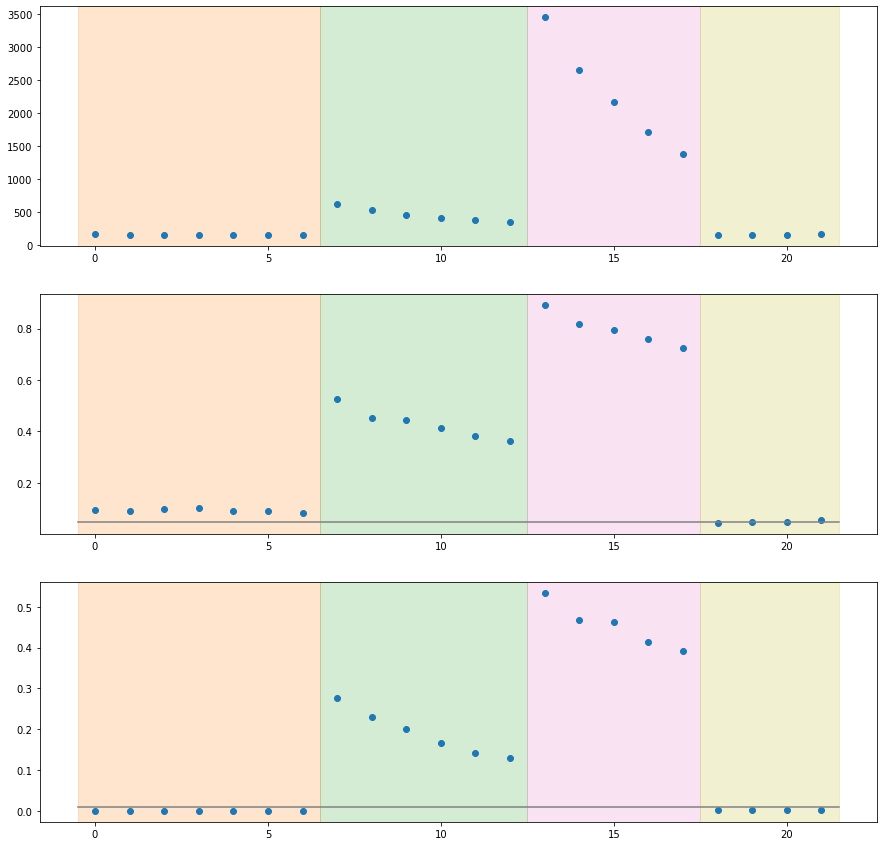

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [21]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  995.  995.  995.  995.] [ 2.60688141  2.63425668  2.65908726  2.66569191  2.66203299  2.67596268
  2.68919639  7.36652007  6.80710433  6.16925427  5.78865764  5.60767214
  5.3960268  34.04710287 31.3018869  25.82690651 21.18732779 17.43975913
  1.45387561  1.48974672  1.53426151  1.59617252] [0.121      0.123      0.131      0.136      0.144      0.147
 0.145      0.385      0.375      0.364      0.361      0.354
 0.341      0.674      0.59       0.57       0.534      0.528
 0.05125628 0.05326633 0.05125628 0.06331658] [0.         0.         0.         0.         0.         0.
 0.         0.128      0.123      0.108      0.095      0.087
 0.083      0.325      0.273      0.262      0.247      0.24
 0.00904523 0.00603015 0.0040201  0.00301508]


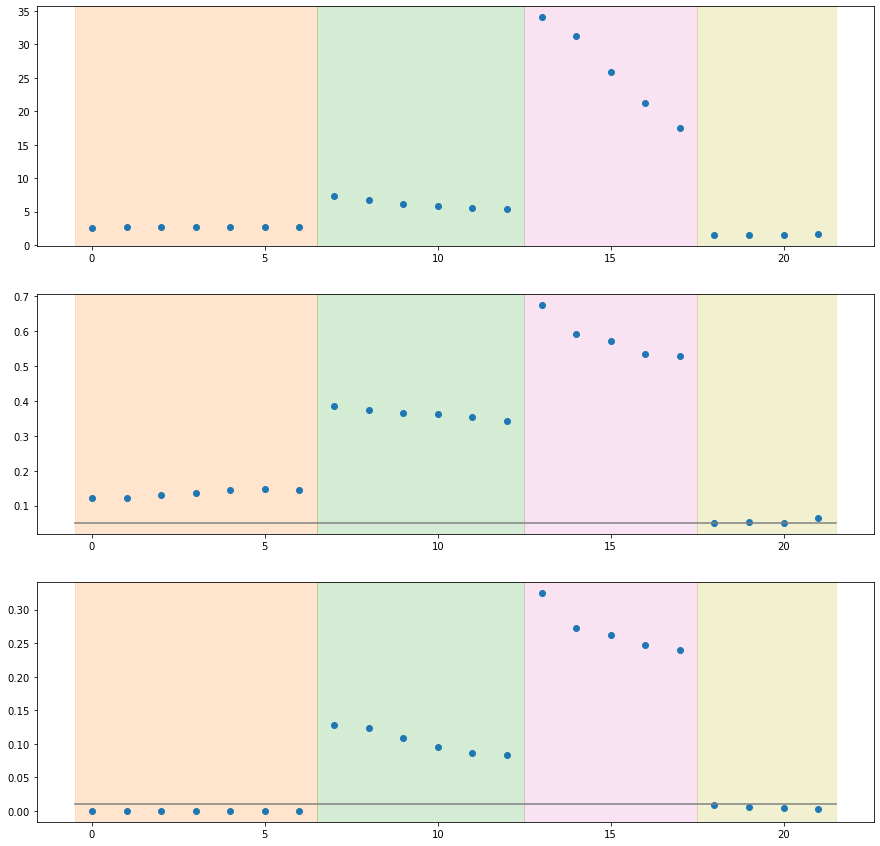

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');